<H1>10,000 USD worth of TKN invested in the Omnipool for one year</H1>

<H3>Effects of new LRNA minting proposal.</H3>
Recently, we discovered that the fee distribution in Omnipool isn't exactly as intended, being offset in a subtle way by impermanent loss from the LRNA minting mechanism. To compensate, we are testing a different LRNA minting mechanism which, if set to maximum, effectively doubles LP returns from fees. Here we set trade volume to 2.5% per day and ramp up the new mechanism from 0 to 100% to show the linear relationship between LRNA mint percentage and fee revenue.

In [12]:
import random
import sys
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run, plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price, value_assets, execute_remove_liquidity
from model.amm.agents import Agent
from model.amm.trade_strategies import invest_all, back_and_forth
from model.amm.global_state import GlobalState

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.05},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': 16541.77, 'weight': 0.10},
    'ETH': {'usd price': 1196.13, 'weight': 0.50},
    'DOT': {'usd price': 1, 'weight': 0.17},
    'TKN': {'usd price': 1, 'weight': 0.03}
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}
asset_fee=0.0025
lrna_fee=0.0005
trade_volume = 2.5

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=asset_fee,
            lrna_fee=lrna_fee,
            withdrawal_fee=False
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in list(assets.keys()) + ['LRNA']},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=trade_volume / 360000 / (1 - asset_fee - lrna_fee)
            )
        ),
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

In [13]:
time_steps = 219000  # int(7200 * 365 / 12)
mint_events = []
mint_percent = []
graph_step = 200
steps = 6
for i in range(steps):
    mint_percent.append(i / (steps - 1))
    initial_state.pools['omnipool'].lrna_mint_pct = mint_percent[-1]
    events = run.run(initial_state, time_steps)
    
    mint_events.append(events[::graph_step])
    mint_events[-1].append(events[-1])
    del events

Starting simulation...
Execution time: 34.185 seconds.
Starting simulation...
Execution time: 34.457 seconds.
Starting simulation...
Execution time: 35.465 seconds.
Starting simulation...
Execution time: 35.449 seconds.
Starting simulation...
Execution time: 36.254 seconds.
Starting simulation...
Execution time: 35.146 seconds.


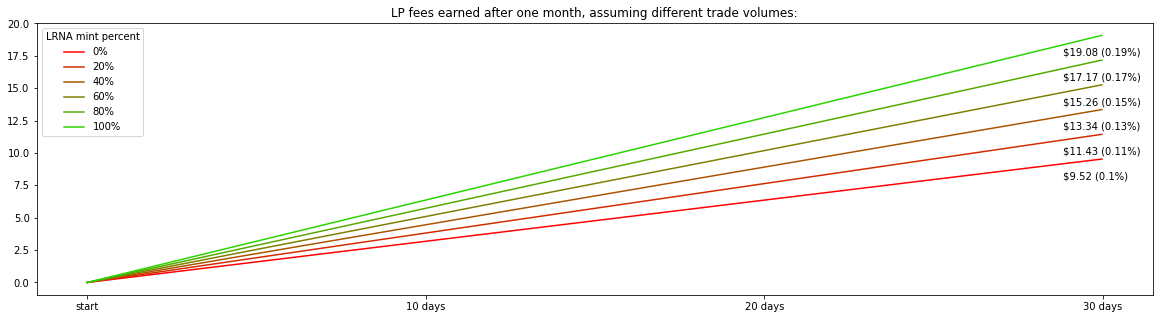

In [14]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after one month:')
graph_length = len(mint_events[1])
plt.xticks(
    [0, graph_length / 3, graph_length / 1.5, graph_length],
    ['start', '10 days', '20 days', '30 days']
)
colors = pu.color_gradient(length=6, color1=(255, 0, 0), color2=(0, 255, 0))
baseline = value_assets(initial_state.external_market, initial_state.agents['LP'].holdings)

mint_returns = [
    [
        (cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline)  # extend to one year
        for event in events
    ]
    for events in mint_events
]

for i, scenario in enumerate(mint_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, -20), textcoords='offset points'
    )

plt.legend(
    [f'{round(percent * 100)}%' for percent in mint_percent],
    title = "LRNA mint percent"
)


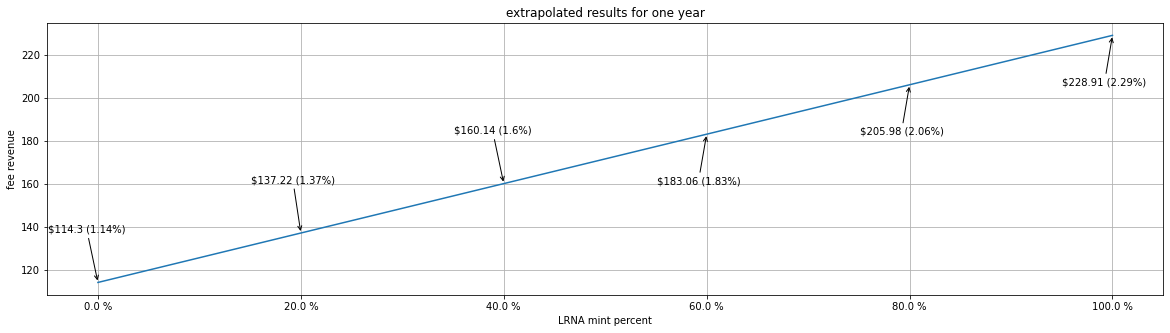

In [16]:
plt.figure(figsize=(20, 5))
plt.title('extrapolated results for one year')
plt.xticks(
    mint_percent,
    [f'{round(percent * 100, 2)} %'  for percent in mint_percent]
)
points = [(mint_percent[i], mint_returns[i][-1] * 12) for i in range(len(mint_percent))]
for i, coors in enumerate(points):
    plt.annotate(
        text=f'${round(coors[1], 2)} ({round(coors[1] / 100, 2)}%)',
        xy=coors,
        xytext=(-50, 50) if i < len(points) / 2 else (-50, -50),
        textcoords='offset points',
        arrowprops={'arrowstyle': '->'}
    )
plt.xlabel('LRNA mint percent')
plt.ylabel('fee revenue')
plt.grid()
plt.plot(mint_percent, [scenario[-1] * 12 for scenario in mint_returns])